In [2]:
import os
import argparse
import cv2
from sklearn.feature_extraction.image import extract_patches_2d
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# load csv 

In [3]:
df = pd.read_csv('/home/workspace2/LUS/Dataset/csv_files/version1_v1.csv', index_col=0)
df.head()

,PatientID,Data_idx,StudyDate,Data_type,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score,study_id
0,24965778,2,20230614,video,NaN,24_32,NaN,NaN,NaN,NaN,1,24965778_2
1,24965778,3,20230614,video,NaN,24_27,NaN,NaN,NaN,NaN,1,24965778_3
2,24965778,4,20230614,video,NaN,NaN,NaN,2_18,NaN,NaN,3_c,24965778_4
3,24965778,5,20230614,video,NaN,NaN,NaN,NaN,1_54,NaN,3_e,24965778_5
4,24965778,6,20230614,video,15_60,NaN,NaN,NaN,NaN,NaN,0,24965778_6


In [4]:
exclusion_std_ids = ['41223316_7', '58262821_3', '76023031_6', '70723403_15', '39009687_11', '39009687_12']

v1_df = df[~df['study_id'].isin(exclusion_std_ids)]

print(len(v1_df))

382


In [5]:
# 해당 열에 대해서 NaN이 아닌 값이 1개인 행을 추출
labels = ['A-line', 'B-line', 'Confluent B-line', 'Consolidation', 'Pleural effusion']
subset_v1_df = v1_df[labels]

# Nan이 아닌 값이 두 개이상 있는 행을 추출하는 조건
mask1 = subset_v1_df.notna().sum(axis=1) == 0
mask1_ = subset_v1_df.notna().sum(axis=1) >= 1

v1_no_label_df = v1_df[mask1]
v1_labeled_df = v1_df[mask1_]

v1_labeled_df = v1_labeled_df.replace('   ', pd.NA)
v1_no_label_df = v1_no_label_df.replace('   ', pd.NA)

print(len(v1_no_label_df))
print(len(v1_labeled_df))

0
382


In [6]:
exclusion_std_ids_v1 = ['39009687_8', '50030114_36', '50030114_44', '48137795_5', '58262821_9']

v1_labeled_df = v1_labeled_df[~v1_labeled_df['study_id'].isin(exclusion_std_ids_v1)]

print(len(v1_labeled_df))

377


In [7]:
video_labeled_df = v1_labeled_df[v1_labeled_df['Data_type'] == 'video']
image_labeled_df = v1_labeled_df[v1_labeled_df['Data_type'] == 'image']
video_labeled_df.head()

,PatientID,Data_idx,StudyDate,Data_type,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score,study_id
0,24965778,2,20230614,video,NaN,24_32,NaN,NaN,NaN,NaN,1,24965778_2
1,24965778,3,20230614,video,NaN,24_27,NaN,NaN,NaN,NaN,1,24965778_3
2,24965778,4,20230614,video,NaN,NaN,NaN,2_18,NaN,NaN,3_c,24965778_4
3,24965778,5,20230614,video,NaN,NaN,NaN,NaN,1_54,NaN,3_e,24965778_5
4,24965778,6,20230614,video,15_60,NaN,NaN,NaN,NaN,NaN,0,24965778_6


In [8]:
video_labeled_df[video_labeled_df['PatientID'] == 14410769]

,PatientID,Data_idx,StudyDate,Data_type,A-line,B-line,Confluent B-line,Consolidation,Pleural effusion,Lung sliding,Lung Ultrasound Score,study_id
387,14410769,1,20231012,video,NaN,12_120,NaN,NaN,NaN,NaN,1,14410769_1
388,14410769,2,20231012,video,NaN,NaN,1_152,NaN,NaN,NaN,2,14410769_2
389,14410769,3,20231012,video,NaN,NaN,1_152,NaN,NaN,NaN,2,14410769_3
390,14410769,4,20231012,video,NaN,NaN,NaN,1_152,NaN,NaN,3_c,14410769_4
391,14410769,5,20231012,video,NaN,1_152,NaN,73_105,NaN,NaN,3_c,14410769_5
392,14410769,6,20231012,video,NaN,NaN,1_152,NaN,NaN,NaN,2,14410769_6
393,14410769,7,20231012,video,NaN,NaN,NaN,1_152,NaN,NaN,3_c,14410769_7
394,14410769,8,20231012,video,NaN,NaN,1_152,NaN,NaN,NaN,2,14410769_8


# load video

In [10]:
raw_video_path1 = '/home/workspace2/LUS/Dataset/5s_video_duplicate_512/14410769/00001.avi'
raw_video_path2= '/home/workspace2/LUS/Dataset/5s_video_duplicate_512/14410769/00004.avi'
# video_10fps_path = '/home/workspace2/LUS/Dataset/10fps_5s_video_duplicate_512/14410769/00001.avi'

cap1 = cv2.VideoCapture(raw_video_path1)
cap2 = cv2.VideoCapture(raw_video_path2)

width1 = cap1.get(cv2.CAP_PROP_FRAME_WIDTH)
height1 = cap1.get(cv2.CAP_PROP_FRAME_HEIGHT)
count1 = cap1.get(cv2.CAP_PROP_FRAME_COUNT)
fps1 = cap1.get(cv2.CAP_PROP_FPS)

width2 = cap2.get(cv2.CAP_PROP_FRAME_WIDTH)
height2 = cap2.get(cv2.CAP_PROP_FRAME_HEIGHT)
count2 = cap2.get(cv2.CAP_PROP_FRAME_COUNT)
fps2 = cap2.get(cv2.CAP_PROP_FPS)

# 새로운 video 생성
np_raw_video1 = np.empty((int(count1), int(height1), int(width1), 3), dtype=np.uint8)
np_raw_video2 = np.empty((int(count2), int(height2), int(width2), 3), dtype=np.uint8)

# 비디오의 각 프레임을 NumPy 배열로 읽어와 저장
for i in range(int(count1)):
    ret, frame = cap1.read()
    if ret:
        np_raw_video1[i] = frame
    else:
        break
        
for i in range(int(count2)):
    ret, frame = cap2.read()
    if ret:
        np_raw_video2[i] = frame
    else:
        break

(150, 512, 512, 3)


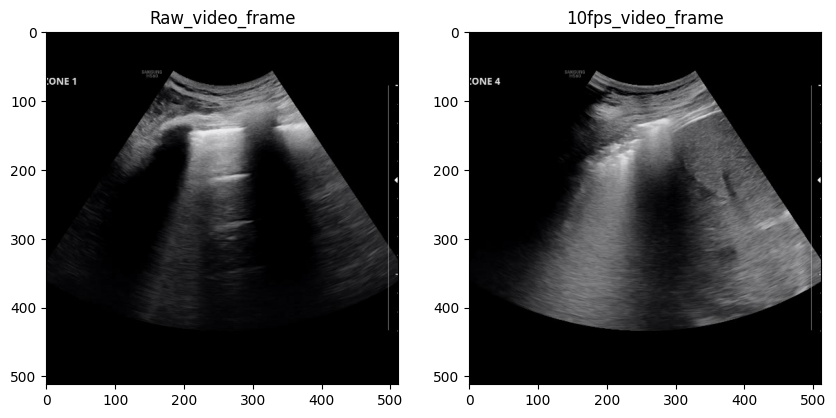

In [13]:
print(np_raw_video1.shape)
plt.figure(figsize=(10, 5))  

plt.subplot(1, 2, 1)  
plt.imshow(np_raw_video1[70], cmap='gray') 
plt.title('Raw_video_frame') 
# plt.axis('off')  


plt.subplot(1, 2, 2)  
plt.imshow(np_raw_video2[70], cmap='gray')  
plt.title('10fps_video_frame')  
# plt.axis('off')  

plt.show()

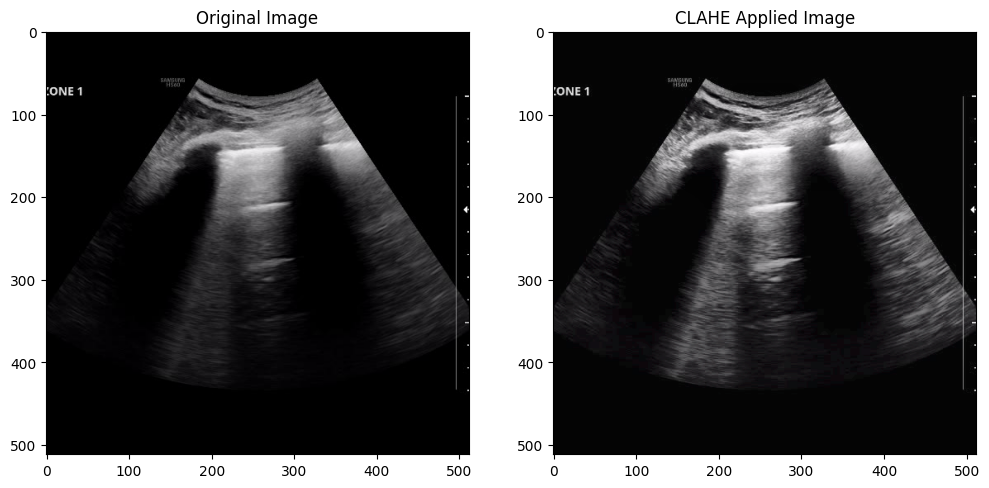

In [14]:
import cv2
from albumentations import Compose, CLAHE
import matplotlib.pyplot as plt

def apply_clahe(image, clip_limit=8.0, tile_grid_size=(8, 8)):
    # CLAHE 변환을 정의
    transform = Compose([
        CLAHE(clip_limit=8.0, tile_grid_size=(8, 8), always_apply=True),
    ])
    
    # 변환 적용
    transformed = transform(image=image)
    transformed_image = transformed["image"]
    
    return transformed_image
transformed_image = apply_clahe(np_raw_video1[70])
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(np_raw_video1[70])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('CLAHE Applied Image')

plt.show()

# method 1 : https://github.com/tomassykora/video-summary/blob/master/summary.py

In [78]:
# 이미지에서 패치를 추출하는 함수
def extract_patches(img, patch_size=128):
    return extract_patches_2d(
        image=img,
        patch_size=(patch_size, patch_size),
        max_patches=100,
        random_state=3,
    )

# 이미지의 히스토그램을 추출하는 함수
def extract_histogram(img):
    return cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

# 두 히스토그램의 교차점을 계산하는 함수
def hist_intersect(hist_a, hist_b):
    return cv2.compareHist(hist_a, hist_b, cv2.HISTCMP_INTERSECT)

## 패치 추출

In [79]:
example_frame_raw = np_raw_video[0]  
example_frame_raw1 = np_raw_video[70]

# example_frame_10fps = np_10fps_video[0]

patches_raw = extract_patches(example_frame_raw)
print(patches_raw.shape)
patches_raw1 = extract_patches(example_frame_raw1)
print(patches_raw1.shape)

# patches_10fps = extract_patches(example_frame_10fps)
# print(patches_10fps.shape)

(100, 128, 128, 3)
(100, 128, 128, 3)


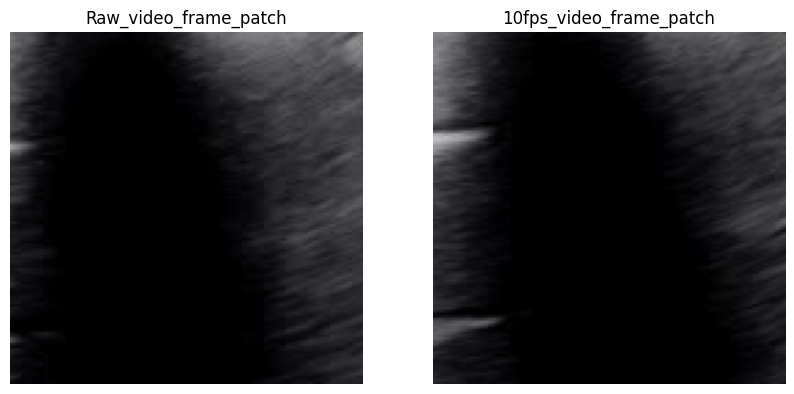

In [82]:
plt.figure(figsize=(10, 5))  

plt.subplot(1, 2, 1)  
plt.imshow(patches_raw[30], cmap='gray') 
plt.title('Raw_video_frame_patch') 
plt.axis('off')  


plt.subplot(1, 2, 2)  
plt.imshow(patches_raw1[30], cmap='gray')  
plt.title('10fps_video_frame_patch')  
plt.axis('off')  

plt.show()

## 해당 패치의 histogram 계산

In [46]:
# 첫 번째 패치의 히스토그램 계산
hist_raw = extract_histogram(patches_10fps[90])
hist_10fps = extract_histogram(patches_10fps[10])

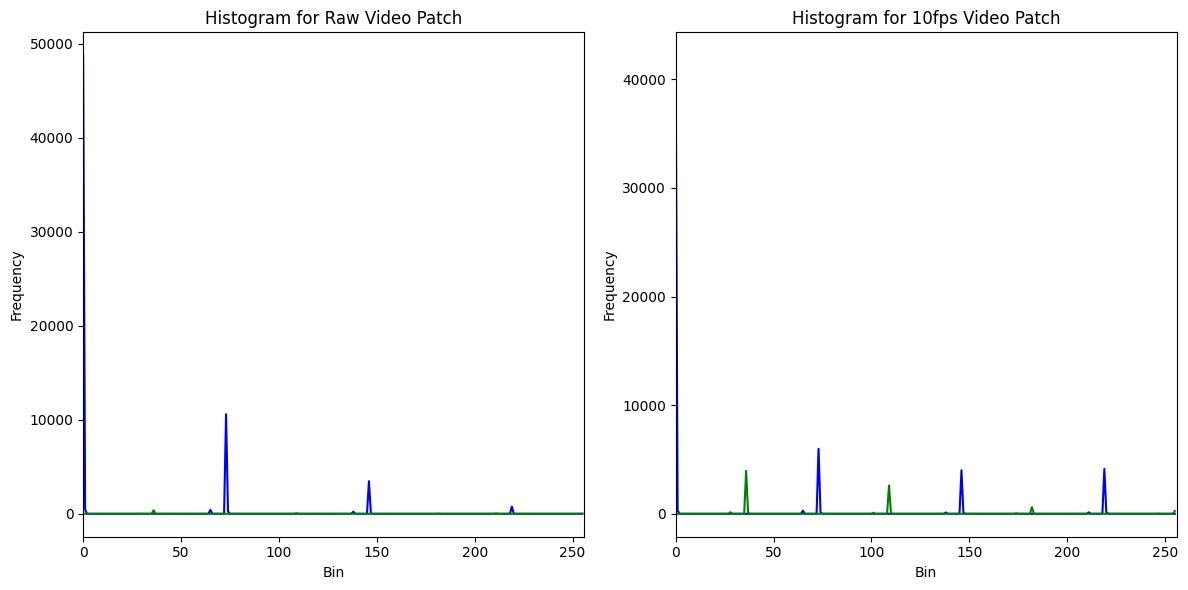

In [47]:
def plot_histogram(hist, title, subplot_position):
    plt.subplot(1, 2, subplot_position)
    for i, col in enumerate(['b', 'g', 'r']):
        plt.plot(hist[i*256:(i+1)*256], color=col)  # 각 채널별로 히스토그램을 그림
        plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel('Bin')
    plt.ylabel('Frequency')

# plot 생성
plt.figure(figsize=(12, 6))

# 첫 번째 패치의 히스토그램을 plot
plot_histogram(hist_raw.flatten(), 'Histogram for Raw Video Patch', 1)

# 두 번째 패치의 히스토그램을 plot
plot_histogram(hist_10fps.flatten(), 'Histogram for 10fps Video Patch', 2)

# plot 표시
plt.tight_layout()
plt.show()

In [48]:
# 두 히스토그램의 교차점 계산
intersection = hist_intersect(hist_raw, hist_10fps)

print(f"교차점: {intersection}")

교차점: 53864.0


# clip 생성

In [15]:
ex_video_path = '/home/workspace2/LUS/Dataset/5s_video_duplicate_512/14410769/00001.avi'

In [16]:
def split_video_into_clips(video_path, clip_length=10, overlap=5):
    # 비디오를 로드합니다.
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    clips = []
    start_frame = 0
    
    while start_frame + clip_length <= total_frames:
        clip = []
        
        for i in range(start_frame, start_frame + clip_length):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                clip.append(frame)
            else:
                break
        
        clips.append(np.array(clip))
        
        # 겹치는 부분 고려 다음 클립의 시작 프레임을 계산 
        start_frame += clip_length - overlap

    return clips

In [17]:
new_clips = split_video_into_clips(ex_video_path)
np_new_clips = np.array(new_clips)
print(np_new_clips.shape)

(29, 10, 512, 512, 3)


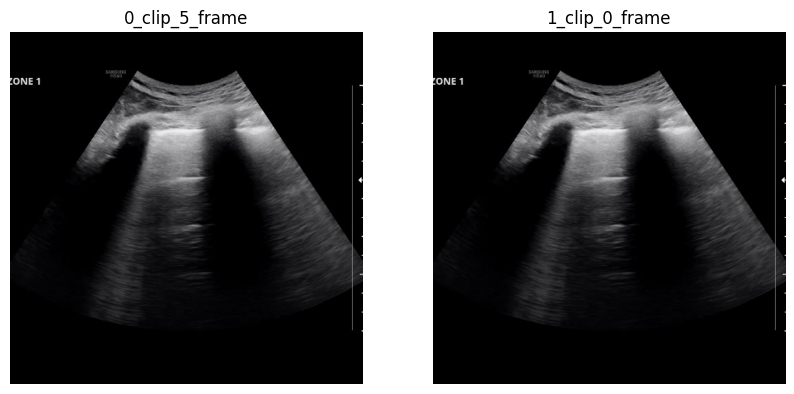

In [18]:
plt.figure(figsize=(10, 10))  

plt.subplot(1, 2, 1)  
plt.imshow(np_new_clips[0][5], cmap='gray') 
plt.title('0_clip_5_frame') 
plt.axis('off')  


plt.subplot(1, 2, 2)  
plt.imshow(np_new_clips[1][0], cmap='gray')  
plt.title('1_clip_0_frame')  
plt.axis('off')   

plt.show()

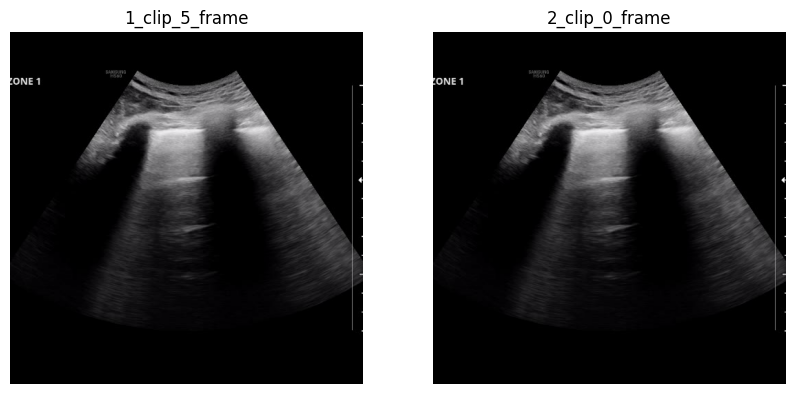

In [19]:
plt.figure(figsize=(10, 10))  

plt.subplot(1, 2, 1)  
plt.imshow(np_new_clips[1][5], cmap='gray') 
plt.title('1_clip_5_frame') 
plt.axis('off')  

plt.subplot(1, 2, 2)  
plt.imshow(np_new_clips[2][0], cmap='gray')  
plt.title('2_clip_0_frame')  
plt.axis('off') 

plt.show()